*Author: Pooya Bagheri*               

**Important Note:** Please ensure not to confuse C (common term used in machine learning) with **Power Loss** which is a power engineering term and is the output variable in our data we are trying to model and predict in this project

# Artificial Neural Networks (ANN)

Our objective since the [previous step](Step2-MLmodels-Linear.ipynb) has been to create an ML model to predict feeder's total power loss based on the voltages measured at the same instant. The first try with applying raw linear regression was a failure, however later, by engaging feature engineering and especially PCA to define new features we reduced the prediction error down to 4.1%. 

As already discussed in the [first step](Step1-DataExploration.ipynb), we know from power circuit theory that relationship of total power loss to node voltages is complicated and nonlinear. That is why a linear regression without any feature engineering was not working. Nonetheless, in this step, we try to engage ANN models which are very capable to represent nonlinear relationships of the data. 

## 1. Loading Data and Scaling

We start the procedure by loading the same amount of data as to the previous step. 

In [1]:
from LoadingDataClass import MLinputData
train=MLinputData(1,5) # Loading Training sets (first 5 days)
test=MLinputData(26,30) # Loading Test sets (last 5 of 30 days)
#Double-checking size of the loaded data sets
print(train.x.shape, train.y.shape, test.x.shape, test.y.shape) 

(7200, 278) (7200, 1) (7200, 278) (7200, 1)


The size of data sets are reasonable and well-expected (see [step 2](Step2-MLmodels-Linear.ipynb)).

Nonlinear ML models including Neural Networks are very sensitive to scaling of the data. We use the standard scaler tool from SKlearn library to scale our data before training the model:

In [2]:
from sklearn.preprocessing import StandardScaler

#Scaling the predictive data sets:
scaler_x=StandardScaler()
x_train=scaler_x.fit_transform(train.x)
x_test=scaler_x.transform(test.x)
#Scaling the output data sets:
scaler_y=StandardScaler()
y_train=scaler_y.fit_transform(train.y)

For example, we can see how our output data (i.e. power loss) in training set  is scaled:

In [3]:
from MyPlotTools import Plot
Plt=Plot(FromDay=1,ToDay=5,plotHeight=12,plotWidth=8)
Plt.Multiple([train.y,y_train],['Before Scaling','After Scaling'],['Power Losss (kW)','Scaled Power Loss'])

<Figure size 800x1200 with 2 Axes>

## 2. Keras Library for Training

For training and testing a neural network, we use the tools from Keras library:

In [15]:
import warnings
warnings.filterwarnings("ignore") #in order to avoid unnecessary warnings when loading Keras modules

from keras.models import Sequential
from keras.layers import Dense

We start by a very classic ANN: one hidden layer with the same width as the input data with a [rectifier (relu)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. The validation_split will be also set as 0.2. This will guide Keras to the last day of five training input data as validation set.

In [5]:
models=[None]*5
models[0]=Sequential()
DataWidth=x_train.shape[1]
models[0].add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu'))
models[0].add(Dense(1,input_dim=DataWidth,kernel_initializer='uniform',activation='linear'))

In [6]:
models[0].compile(optimizer='Adam' ,loss='mse',metrics=['mse'])
LearningHistory=models[0].fit(x_train,y_train,validation_split=0.2, batch_size=1,epochs=15, shuffle=True)
y_predicted=scaler_y.inverse_transform(models[0].predict(x_test))

Train on 5760 samples, validate on 1440 samples
Epoch 1/15
5760/5760 [==============================] - 6s 1ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 2/15
5760/5760 [==============================] - 6s 1ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 3/15
5760/5760 [==============================] - 6s 1ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.1034 - val_mean_squared_error: 0.1034
Epoch 4/15
5760/5760 [==============================] - 6s 1ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 5/15
5760/5760 [==============================] - 6s 961us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0545 - val_mean_squared_error: 0.0545
Epoch 6/15
5760/5760 [==============================] - 6s 984us/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.03

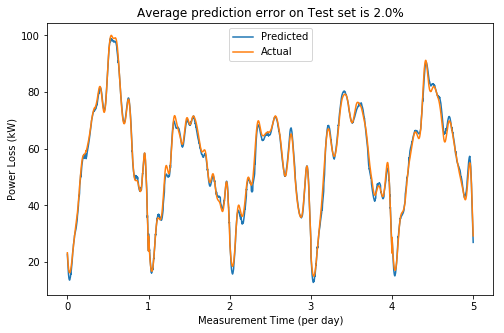

In [7]:
Plt.Resize(5,8)
Plt.AssessPrediction(y_predicted,test.y)

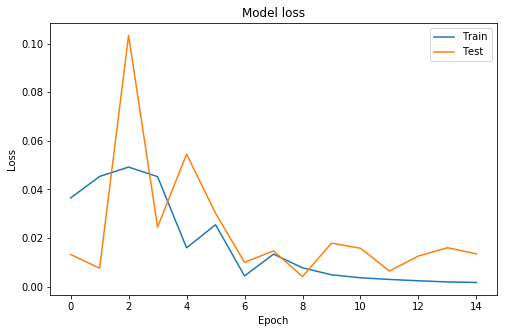

In [8]:
Plt.LearningCurve(LearningHistory)

There are some point that validation error starts to increase which means overfitting. Therefore, we want to save the best weights of the model during training. For this purpose we will use checkpoint callbacks in Keras library and create a new model to train:

In [9]:
#Creating Checkpoint
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("ANNweights1-best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
#Creating a new model with same structure (to include checkpoint in its training):
models[1]=Sequential()
models[1].add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu'))
models[1].add(Dense(1,input_dim=DataWidth,kernel_initializer='uniform',activation='linear'))

In [10]:
#Compile and train the model
models[1].compile(optimizer='Adam' ,loss='mse',metrics=['mse'])
LearningHistory=models[1].fit(x_train,y_train,validation_split=0.2, batch_size=1,epochs=20,callbacks=[checkpoint] ,shuffle=True)
y_predictedEnd=scaler_y.inverse_transform(models[1].predict(x_test))
#Loading the best model from checkpoint:
models[1].load_weights("ANNweights1-best.hdf5")
y_predictedBest=scaler_y.inverse_transform(models[1].predict(x_test))

Train on 5760 samples, validate on 1440 samples
Epoch 1/20
5760/5760 [==============================] - 6s 1ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0536 - val_mean_squared_error: 0.0536

Epoch 00001: val_mean_squared_error improved from inf to 0.05357, saving model to ANNweights1-best.hdf5
Epoch 2/20
5760/5760 [==============================] - 6s 990us/step - loss: 0.0592 - mean_squared_error: 0.0592 - val_loss: 0.0111 - val_mean_squared_error: 0.0111

Epoch 00002: val_mean_squared_error improved from 0.05357 to 0.01107, saving model to ANNweights1-best.hdf5
Epoch 3/20
5760/5760 [==============================] - 6s 1ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00003: val_mean_squared_error improved from 0.01107 to 0.00397, saving model to ANNweights1-best.hdf5
Epoch 4/20
5760/5760 [==============================] - 7s 1ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0029 - va

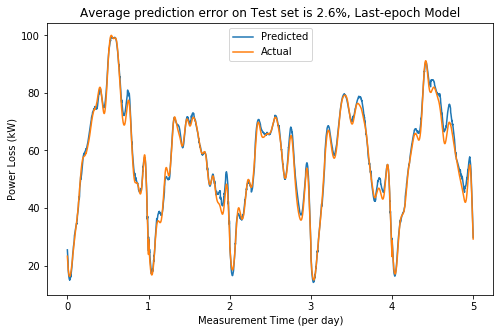

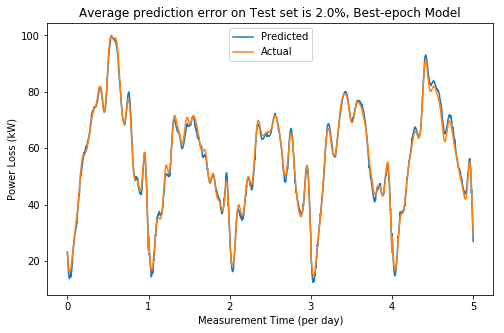

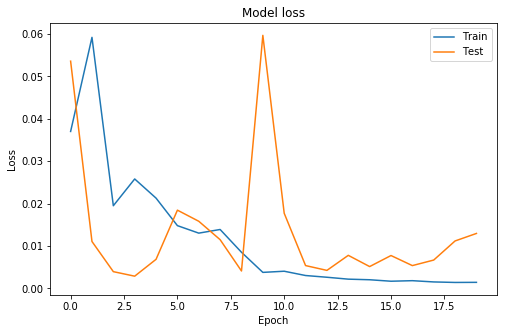

In [11]:
Plt.AssessPrediction(y_predictedEnd,test.y,TitleAddOn=", Last-epoch Model")
Plt.AssessPrediction(y_predictedBest,test.y,TitleAddOn=", Best-epoch Model")
Plt.LearningCurve(LearningHistory)

## 3. More Layers in the network

So, how can we improve our error to be lower than 2%. One apparent way is to add more layers to our ANN. This will give more parameters to our model and gives it more flexibility to better represent  the complexities between our predictive and response variables. Since our network is larger and have many more parameters to optimize, we let the training to continue for more epochs:

In [12]:
#Creating a new model 
models[2]=Sequential()
models[2].add(Dense(int(DataWidth), input_dim=DataWidth,kernel_initializer='uniform',activation='relu'))
#adding one more layer with a width half of the width of the first layer
models[2].add(Dense(int(DataWidth/2), input_dim=DataWidth,kernel_initializer='uniform',activation='relu'))
models[2].add(Dense(1,input_dim=int(DataWidth/2),kernel_initializer='uniform',activation='linear'))
#Add checkpoint, compile and train the model
checkpoint = ModelCheckpoint("ANNweights2-best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
models[2].compile(optimizer='Adam' ,loss='mse',metrics=['mse'])
LearningHistory=models[2].fit(x_train,y_train,validation_split=0.2, batch_size=1,epochs=30,callbacks=[checkpoint] ,shuffle=True)
#Loading the best model from checkpoint and doing prediction on test:
models[2].load_weights("ANNweights2-best.hdf5")
y_predicted=scaler_y.inverse_transform(models[2].predict(x_test))

Train on 5760 samples, validate on 1440 samples
Epoch 1/30
5760/5760 [==============================] - 8s 1ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0344 - val_mean_squared_error: 0.0344

Epoch 00001: val_mean_squared_error improved from inf to 0.03437, saving model to ANNweights2-best.hdf5
Epoch 2/30
5760/5760 [==============================] - 7s 1ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0107 - val_mean_squared_error: 0.0107

Epoch 00002: val_mean_squared_error improved from 0.03437 to 0.01075, saving model to ANNweights2-best.hdf5
Epoch 3/30
5760/5760 [==============================] - 7s 1ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0046 - val_mean_squared_error: 0.0046

Epoch 00003: val_mean_squared_error improved from 0.01075 to 0.00459, saving model to ANNweights2-best.hdf5
Epoch 4/30
5760/5760 [==============================] - 7s 1ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0045 - val_

And let's see the results:

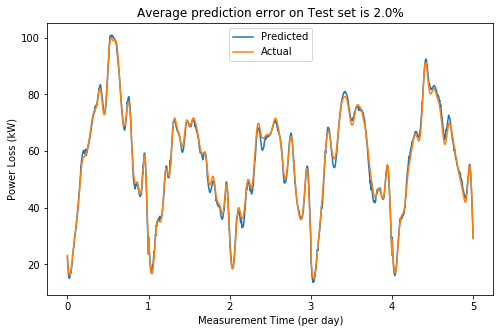

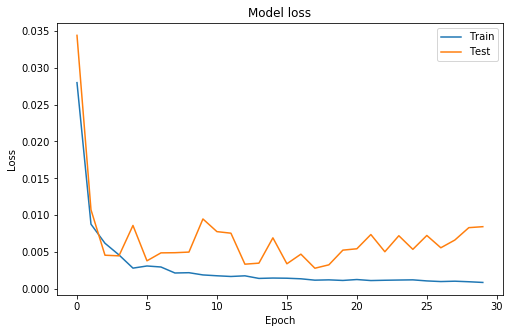

In [13]:
Plt.AssessPrediction(y_predicted,test.y)
Plt.LearningCurve(LearningHistory)

The prediction error is improved but only a bit. From above plot, we can see that losses somehow stop decreasing after 10 epochs. How can we improve on this? We have already added to complexity of network, but the other way to improve our training procedure is provide more training samples. Remember that we have so far only loaded first 5 days of the data and there is still 20 days left (the last 5 days always belong to the test set!). We can try training the model with loading all 25 days, but that gives us memory problems. In the [next step](Step4-ANN-IncrementalLoading.ipynb), we will implement an incremental data loading process to overcome this issue. 

However, before bringing this notebook to an end, let's do a curious investigation on the effect of batch size in our training:

## 5. Effect of Batch Size

Thus far, we have only chosen the batch size of 1 in our training. This means our training algorithm makes a gradient update by taking each one of the samples. This is not very unreasonable since we didn't have many number of samples so far (5760 samples). And it's like we extract some learning benefit from each individual sample. However, choosing a small batch size is not always the best. It means that each epoch will take much longer and can result is slow training. In addition, if we sit back and look on the overall mathematical ML architecture, the natural choice would have been to use the whole sample set for each gradient upgrade (i.e. batch size = epoch). But, that turns to be very unpractical! In practice, the batch size is usually chosen much smaller than the epoch size.

Nonetheless, choosing the best batch size always ends up depending on the nature of problem at hand and the data you have. Let's empirically investigate how batch size affects the quality of training on our very own data here:

In [14]:
from sklearn.metrics import mean_absolute_error 
#List of batch sizes to try:
BatchSizeList=[1,5,10,25,60,120,500,1440]

for i,BatchSize in enumerate(BatchSizeList):
    #restarting model for each batch size
    models[3]=Sequential()
    models[3].add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu'))
    models[3].add(Dense(int(DataWidth/2), input_dim=DataWidth,kernel_initializer='uniform',activation='relu'))
    models[3].add(Dense(1,input_dim=DataWidth,kernel_initializer='uniform',activation='linear'))
    #Add checkpoint, compile and train the model
    checkpoint = ModelCheckpoint("ANNweights3-best.hdf5", monitor='val_mean_squared_error', verbose=0, save_best_only=True, mode='min')
    models[3].compile(optimizer='Adam' ,loss='mse',metrics=['mse'])
    LearningHistory=models[3].fit(x_train,y_train,validation_split=0.2, batch_size=BatchSize,epochs=30,callbacks=[checkpoint] ,shuffle=True, verbose=0)
    #Loading the best model from checkpoint:
    models[3].load_weights("ANNweights3-best.hdf5")
    y_predicted=scaler_y.inverse_transform(models[3].predict(x_test))
    PredictionError=mean_absolute_error(y_predicted,test.y)/test.y.mean()*100
    print('Prediction error acheived by batch_size=%d : %.2f%%' % (BatchSize,PredictionError))

Prediction error acheived by batch_size=1 : 1.92%
Prediction error acheived by batch_size=5 : 2.02%
Prediction error acheived by batch_size=10 : 2.15%
Prediction error acheived by batch_size=25 : 3.21%
Prediction error acheived by batch_size=60 : 3.25%
Prediction error acheived by batch_size=120 : 4.34%
Prediction error acheived by batch_size=500 : 3.81%
Prediction error acheived by batch_size=1440 : 4.34%


We can see smaller errors for the smaller batch sizes. This result somehow verify our above discussion that a very small batch_size such as 1 seems to quite work well for our case here, since we have a limited number of samples.

Once we engage incremental data loading in the [next step](Step4-ANN-IncrementalLoading.ipynb), we will have access to more samples for training and that will open the door for larger batch sizes to deliver results. 